In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

from collections import OrderedDict 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12.7,10.27)})

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
#torch.manual_seed(123)

from dutils import Experiment
from trainer import fit
import visualization as vis
from tcga_datasets import SiameseDataset
import numpy as np
cuda = torch.cuda.is_available()
print("Cuda is available: {}".format(cuda))

# Models
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

Cuda is available: True


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score as ANMI

In [68]:
def getTCGA(disease):
    path = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP/TCGA/TCGA_{}_counts.tsv.gz"
    files = [path.format(d) for d in disease]
    return files


def readGCP(files, biotype='protein_coding', mean=True):
    """
    Paths to count matrices.
    """
    data_dict = {}
    for f in files:
        key = os.path.basename(f).split("_")[1]
        data = pd.read_csv(f, sep='\t', index_col=0)
        # transcript metadata
        meta = pd.DataFrame([row[:-1] for row in data.index.str.split("|")],
                            columns=['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'GENE', 'BP', 'BIOTYPE'])
        meta = pd.MultiIndex.from_frame(meta)
        data.index = meta
        # subset transcripts
        data = data.xs(key=biotype, level='BIOTYPE')
        data = data.droplevel(['ENST', 'ENSG', 'OTTHUMG', 'OTTHUMT', 'GENE-NUM', 'BP'])
        # average gene expression of splice variants
        data = data.T
        if mean:
            data = data.groupby(by=data.columns, axis=1).mean()
        data_dict[key] = data
    return data_dict


def uq_norm(df, q=0.75):
    """
    Upper quartile normalization of GEX for samples.
    """
    quantiles = df.quantile(q=q, axis=1)
    norm = df.divide(quantiles, axis=0)
    return norm

In [69]:
def generate_fsets(data, n, steps=5):
    n = np.linspace(start=1, stop=data.shape[1], num=steps, dtype='int')
    idx = [np.random.randint(low=1, high=data.shape[1], size=i) for i in n]
    return idx

In [70]:
def process_data():
    base = "/srv/nas/mk2/projects/pan-cancer/TCGA_CCLE_GCP"
    disease = ['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM']

    tcga_files = getTCGA(disease)
    tcga_meta = pd.read_csv(os.path.join(base, "TCGA/TCGA_GDC_ID_MAP.tsv"), sep="\t")
    tcga_raw = readGCP(tcga_files, mean=True)
    # combine samples
    tcga_raw = pd.concat(tcga_raw.values())
    # Upper quartile normalization
    tcga_raw = uq_norm(tcga_raw)
    # log norm
    tcga = tcga_raw.transform(np.log1p)
    return tcga, tcga_meta

### Setup

In [71]:
exp_dir = "/srv/nas/mk2/projects/pan-cancer/experiments/feat_selection_short_range"

In [72]:
tcga, tcga_meta = process_data()

In [73]:
feature_idx = generate_fsets(tcga, steps=20)

In [74]:
hierarchy = OrderedDict({'Disease':['BRCA', 'LUAD', 'KIRC', 'THCA', 'PRAD', 'SKCM'],
                         'Sample Type':['Primary Tumor', 'Solid Tissue Normal']})

In [75]:
# Define experiment
exp = Experiment(meta_data=tcga_meta,
                 hierarchy=hierarchy,
                 index='CGHubAnalysisID',
                 cases='Case ID',
                 min_samples=20)
# Train / Test split
exp.train_test_split(cases='Case ID')
# Return data 
train_data, train_labels = exp.get_data(tcga, subset="train", dtype=np.float32)
test_data, test_labels = exp.get_data(tcga, subset="test", dtype=np.float32)

In [76]:
experiments = {'experiment': exp,
               'train':(train_data, train_labels),
               'test': (test_data, test_labels)}
pd.to_pickle(experiments, os.path.join(exp_dir, "experiment_meta_data.pkl"))

### Network

In [77]:
def feature_training(train_data, train_labels, test_data, test_labels, feature_idx, exp_dir, cuda=True):
    # Meta data
    meta_data = {"n_features":[],
                 "model":[],
                 "ANMI":[]}
    # Params
    batch_size = 8
    kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {'num_workers': 10}
    
    # Feature Index
    for batch, feat in enumerate(feature_idx):
        print("Batch {}\n".format(batch))
        exp_data = {'feature_idx':feat}
        # Define data
        siamese_train_dataset = SiameseDataset(data=train_data.iloc[:,feat],
                                           labels=train_labels,
                                           train=True)
        siamese_test_dataset = SiameseDataset(data=test_data.iloc[:,feat],
                                          labels=test_labels,
                                          train=False)
        # Loaders
        siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
        siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)
        # Instantiate model
        n_samples, n_features = siamese_train_dataset.train_data.shape
        for i in range(3):
            nmodel = 'model_{}'.format(i)
            print("\t{}".format(nmodel))
            embedding_net = EmbeddingNet(n_features, 2)
            model = SiameseNet(embedding_net)
            if cuda:
                model.cuda()
            # Parameters
            margin = 1.
            loss_fn = ContrastiveLoss(margin)
            lr = 1e-3
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
            n_epochs = 10
            log_interval = round(len(siamese_train_dataset)/4/batch_size)
            # Train
            train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
                                       n_epochs, cuda, log_interval)
            # Test Embeddings
            val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(siamese_test_dataset.test_data, siamese_test_dataset.labels, model)
            # Evaluation
            n_clusters = len(np.unique(test_labels))
            kmeans = KMeans(n_clusters=n_clusters)
            siamese_clusters = kmeans.fit_predict(val_embeddings_baseline)
            anmi = ANMI(siamese_clusters, val_labels_baseline)
            # Store
            meta_data['n_features'].append(len(feat))
            meta_data['model'].append(nmodel)
            meta_data['ANMI'].append(anmi)
            exp_data[nmodel] = {'data': (val_embeddings_baseline, val_labels_baseline),
                                'loss': (train_loss, val_loss),
                                'ANMI': anmi}
        pd.to_pickle(exp_data, os.path.join(exp_dir, "model_{}.pkl".format(len(feat))))
    pd.to_pickle(meta_data, os.path.join(exp_dir, "model_meta_data.pkl"))

In [ ]:
feature_training(train_data, train_labels, test_data, test_labels, feature_idx, exp_dir)

Batch 0

	model_0
Train: [0/2931 (0%)]	Loss: 0.249634
Train: [736/2931 (25%)]	Loss: 0.152036
Train: [1472/2931 (50%)]	Loss: 0.147319
Train: [2208/2931 (75%)]	Loss: 0.131673
Epoch: 1/10. Train set: Average loss: 0.1495
Epoch: 1/10. Validation set: Average loss: 0.1442
Train: [0/2931 (0%)]	Loss: 0.144352
Train: [736/2931 (25%)]	Loss: 0.139277
Train: [1472/2931 (50%)]	Loss: 0.152814
Train: [2208/2931 (75%)]	Loss: 0.126896
Epoch: 2/10. Train set: Average loss: 0.1431
Epoch: 2/10. Validation set: Average loss: 0.1435
Train: [0/2931 (0%)]	Loss: 0.127687
Train: [736/2931 (25%)]	Loss: 0.125690
Train: [1472/2931 (50%)]	Loss: 0.148162
Train: [2208/2931 (75%)]	Loss: 0.123394
Epoch: 3/10. Train set: Average loss: 0.1364
Epoch: 3/10. Validation set: Average loss: 0.1439
Train: [0/2931 (0%)]	Loss: 0.123228
Train: [736/2931 (25%)]	Loss: 0.143601
Train: [1472/2931 (50%)]	Loss: 0.137843
Train: [2208/2931 (75%)]	Loss: 0.108979
Epoch: 4/10. Train set: Average loss: 0.1336
Epoch: 4/10. Validation set: Ave

In [79]:
foo = pd.read_pickle("/srv/nas/mk2/projects/pan-cancer/experiments/model_meta_data.pkl")

In [82]:
foo = pd.DataFrame(foo)

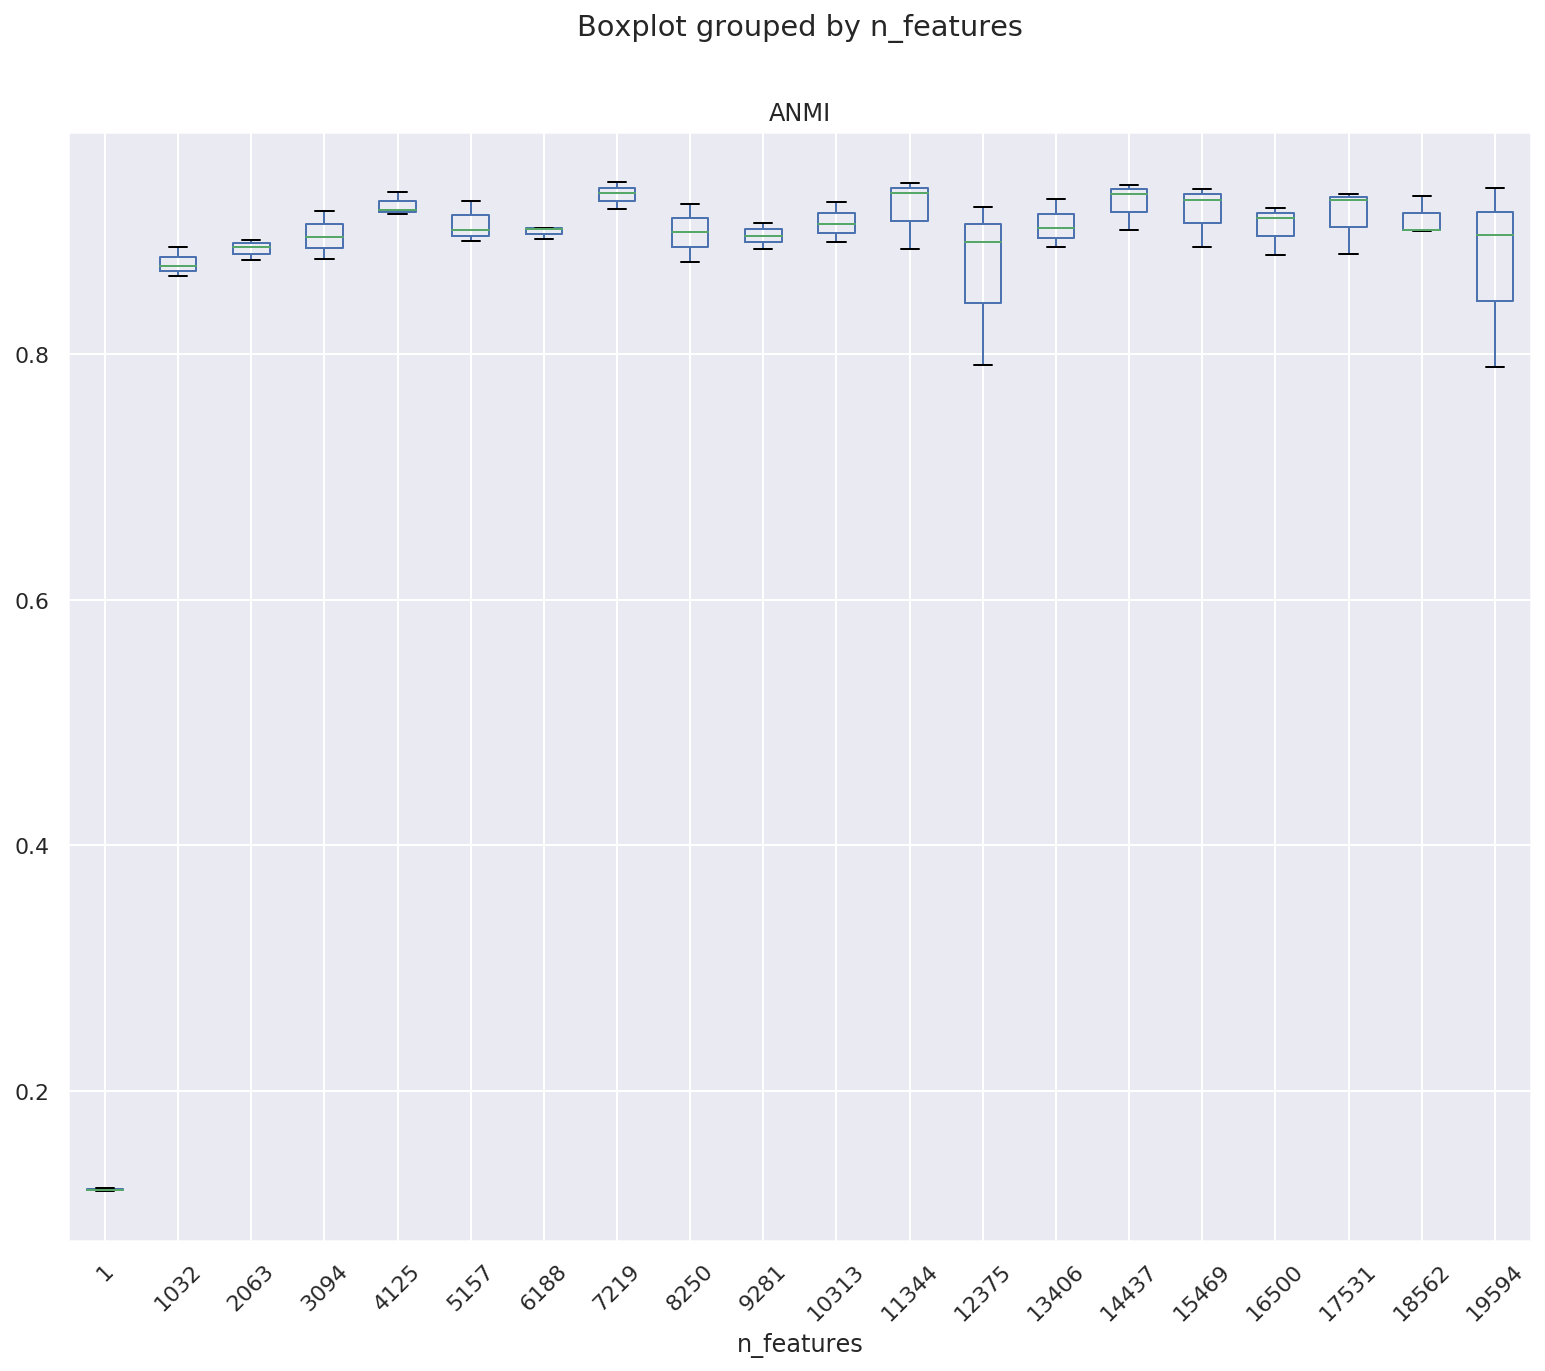

In [89]:
foo.boxplot(by='n_features', column='ANMI', rot=45)